In [46]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.feature_selection import chi2, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import requests

from census import Census
from us import states
from config import akey
c = Census(akey)

import seaborn as sns
sns.set(color_codes=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 20, 15
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import Sports Data

mlb_data_file = "Resources/mlb.csv"
mlb_attendance_file = "Resources/mlb_attendance.csv"
mlb_locations_file = "Resources/mlb_loc.csv"
nfl_data_file = "Resources/nfl.csv"
nfl_attendance_file = "Resources/nfl_attendance.csv"
nfl_locations_file = "Resources/nfl_loc.csv"
nba_data_file = "Resources/nba.csv"
nba_attendance_file = "Resources/nba_attendance.csv"
nba_locations_file = "Resources/nba_loc.csv"

mlb_df = pd.read_csv(mlb_data_file, low_memory = False)
mlb_locations_df = pd.read_csv(mlb_locations_file, low_memory = False)

nfl_df = pd.read_csv(nfl_data_file, low_memory = False)
nfl_location_df = pd.read_csv(nfl_locations_file, low_memory = False)

nba_df = pd.read_csv(nba_data_file, low_memory = False)
nba_locations_df = pd.read_csv(nba_locations_file, low_memory = False)

In [5]:
def nfl_team(x):
   nfl_data=nfl_df[nfl_df["Tm"] == x].reset_index(drop=True)
   return(nfl_data)
def nba_team(x):
   nba_data=nba_df[nba_df["Team"]==x].reset_index(drop=True)
   return(nba_data)
def mlb_team(x):
   mlb_data=mlb_df[mlb_df['team']==x].reset_index(drop=True)
   return(mlb_data)

In [6]:
nfl_location_df = pd.read_csv(nfl_locations_file, dtype = {'State Name':'str',
                                                          'NFL Teams':'str',
                                                          'Stadium City':'str',
                                                          'Zip Codes':'str'
                                                          ,'organization' : 'str'}, low_memory = False)

### Understanding the Census JSON
Many statistics that the Census reports on are not accessible from the `census` package. However, those reports have IDs similar to how `census` calls the ones it can. These can be seen and compared against using the UI found on [US Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t). Here you can see the sets of reports available by id based off your selection. ACS 5-year estimates were used for the majority of this study, and can be filtered in the selection.

## Census JSON pages

The [Census Developer's Page](https://www.census.gov/data/developers/data-sets/acs-5year.html) shows how to make a JSON call to the different tables. Notice the addition of `subject?` to the subject table calls. This is essentially where the break from the `census` package occurs, and why not all tables can be called. These call urls are the crux of the data mining scripts to obtain census data.

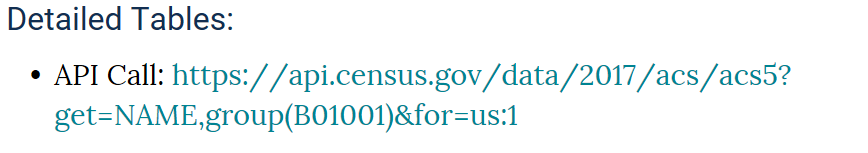
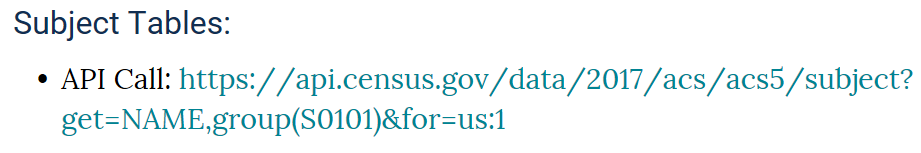


In [7]:
# urls of detailed & subject tables with example 
url = 'https://api.census.gov/data/2016/acs/acs5/subject?get=NAME,S1902_C01_001E,S2409_C05_006E&for=zip%20code%20tabulation%20area:*'
urlg = 'https://api.census.gov/data/2017/acs/acs5?get=NAME,group(B01001)&for=us:1'

#url fixed variables
urlbeg = 'https://api.census.gov/data/'
urlmid = '/acs/acs5/subject?get=NAME,'
urlend = '&for=zip%20code%20tabulation%20area:*'

# reports, while independently stored in list by name
#, are a single string within the call

reports = 'S1902_C01_001E,S2409_C05_006E'
reportnames = ['PercentFemaleEmployed','EstMeanIncAll']

# The looped variable in the calls are the years
years = ['2016', '2017']

# Intialize empty list to store call urls and json requests of reports
url_list = []
reports_list =  []


#yr = [year for year in years]
urls = [(urlbeg + year + urlmid + reports + urlend) for year in years]


reports = [requests.get(url).json() for url in urls]

    
#lists = [[g[3], g[2], g[1]] for g in reports[0][1:]]


df_full = pd.DataFrame()
for i, year in enumerate(years):
    df_one = pd.DataFrame([[g[3], g[2], g[1]] for g in reports[i][1:]], columns = ['zip'] + reportnames)
    df_one['year'] = years[i]
    df_full = df_full.append(df_one, ignore_index=True).reset_index(drop=True)

#estimate = pd.DataFrame([lists], columns = ['zip'] + reportnames)
#estimate2 = pd.DataFrame([{g[3], g[2], g[1] for g in reports[1][1:]]}, columns = ['zip'] + reportnames)



In [8]:
df_full.head()

zip PercentFemaleEmployed EstMeanIncAll  year
0  01001                  53.7          7190  2016
1  01002                  50.6          9561  2016
2  01003          -666666666.0            26  2016
3  01005                   0.0          1840  2016
4  01007                  64.8          5611  2016

In [9]:
df_full.EstMeanIncAll = df_full.EstMeanIncAll.astype(int)

In [10]:
nfl_df.head()

year                 Tm   W   L  T   W-L%   PF   PA  wildcard_w  \
0  2018  Arizona Cardinals   3  13  0  0.188  225  425           0   
1  2018    Atlanta Falcons   7   9  0  0.438  414  423           0   
2  2018   Baltimore Ravens  10   6  0  0.625  389  287           0   
3  2018      Buffalo Bills   6  10  0  0.375  269  374           0   
4  2018  Carolina Panthers   7   9  0  0.438  376  382           0   

   wildcard_l  div_w  div_l  conf_w  conf_l  sb_w  sb_l organization  
0           0      0      0       0       0     0     0          nfl  
1           0      0      0       0       0     0     0          nfl  
2           1      0      0       0       0     0     0          nfl  
3           0      0      0       0       0     0     0          nfl  
4           0      0      0       0       0     0     0          nfl

In [11]:
df_full['zip'] = df_full['zip'].astype('str')

In [12]:
NFLCensusDF= pd.merge(df_full, nfl_location_df, left_on = 'zip', right_on = 'Zip Codes').sort_values('EstMeanIncAll')

In [13]:
NFL_Full = pd.merge(nfl_location_df, nfl_df, left_on = 'NFL Team(s)', right_on = 'Tm' )
NFL_Full.head()

State Name        NFL Team(s) Stadium City Zip Codes organization_x  year  \
0    Arizona  Arizona Cardinals  Glendale,AZ     85305            nfl  2018   
1    Arizona  Arizona Cardinals  Glendale,AZ     85305            nfl  2017   
2    Arizona  Arizona Cardinals  Glendale,AZ     85305            nfl  2016   
3    Arizona  Arizona Cardinals  Glendale,AZ     85305            nfl  2015   
4    Arizona  Arizona Cardinals  Glendale,AZ     85305            nfl  2014   

                  Tm   W   L  T       ...         PA  wildcard_w  wildcard_l  \
0  Arizona Cardinals   3  13  0       ...        425           0           0   
1  Arizona Cardinals   8   8  0       ...        361           0           0   
2  Arizona Cardinals   7   8  1       ...        362           0           0   
3  Arizona Cardinals  13   3  0       ...        313           0           0   
4  Arizona Cardinals  11   5  0       ...        299           0           1   

   div_w  div_l  conf_w  conf_l  sb_w  sb_l  organization_y  
0      0      0       0       0     0     0             nfl  
1      0      0       0       0     0     0             nfl  
2      0      0       0       0     0     0             nfl  
3      1      0       0       1     0     0             nfl  
4      0      0       0       0     0     0             nfl  

[5 rows x 22 columns]

In [14]:
NFL_Sliced = NFL_Full[['year', 'NFL Team(s)', 'Zip Codes', 'W-L%']]
NFL_Sliced['W-L%']= NFL_Full['W-L%'].astype(float)
NFL_Sliced['W-L%']= NFL_Full['W-L%']*100
df_full['year'] = df_full['year'].astype(int)
df_full['PercentFemaleEmployed'] = df_full['PercentFemaleEmployed'].astype(float)

In [15]:
df_full['year'].dtypes

dtype('int32')

In [16]:
NFLCensusDF= pd.merge(df_full, NFL_Sliced, left_on = ['year','zip'], right_on = ['year','Zip Codes']).sort_values('EstMeanIncAll')
NFLCensusDF.loc[NFLCensusDF.PercentFemaleEmployed == -666666666.0, ['PercentFemaleEmployed']] = np.nan


In [27]:
# nfl_location_df['Zip Codes'] = nfl_location_df['Zip Codes'].astype('str')
NFLCensusDF = NFLCensusDF.dropna()
NFLCensusDF = NFLCensusDF.reset_index(drop=True).head()

In [18]:
NFLCensusDF['zip'].count()

57

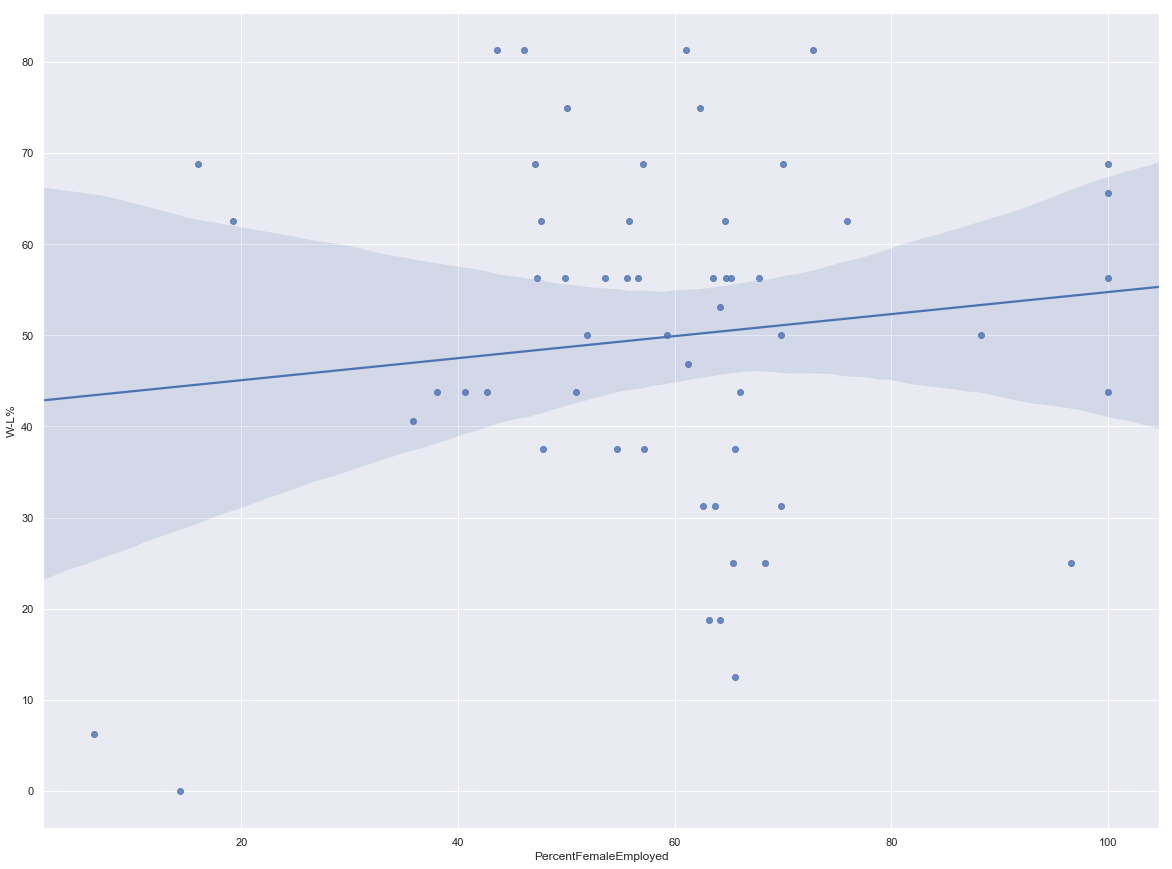

In [19]:
sns.regplot(x="PercentFemaleEmployed", y="W-L%", data=NFLCensusDF)

In [44]:
x = NFLCensusDF['PercentFemaleEmployed'].values
x = x.reshape(-1,1)
y = NFLCensusDF['W-L%'].values
y = y.reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
#scores, pvalues = chi2(x, y)
regression = f_regression(x,y,center=True)

print(regression)

(array([0.47311308]), array([0.54096852]))


In [47]:
stats.f_oneway(x,y)

F_onewayResult(statistic=array([23.5478692]), pvalue=array([0.00126764]))